### Setting up and making installations

In [2]:
!pip install torchinfo captum split-folders

     |████████████████████████████████| 1.4 MB 58.7 MB/s eta 0:00:01


In [3]:
%run primutils

In [4]:
import logging
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import mlflow
import azureml.core
from azureml.core import Workspace, Dataset, Experiment, Run, Model

import torch
import torch.nn.functional as F
from torch.utils.data.dataloader import DataLoader
import torchvision.transforms as T
import torchvision.models as models
from torchvision.datasets import ImageFolder
from torchinfo import summary
from torchvision.utils import make_grid

import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib.colors import LinearSegmentedColormap
from PIL import Image

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score

import captum
from captum.attr import LayerGradCam, LayerAttribution
from captum.attr import visualization as viz

import shutil
import json
import splitfolders
from textwrap import wrap
from datetime import datetime
#from utils.demoutils import train, plot_learning_curve, to_categorical, predict_loader, inverse_normalize, plot_confusion_matrix

## Connect to Azure ML Workspace and Workflow

In [5]:
logging.basicConfig(filename='experiment.log', filemode = 'w', format='%(levelname)s: %(message)s')
logger=logging.getLogger()
logger.setLevel(logging.INFO)

def record(entry, console=True, logfile=True):
    ''' log entry to console and/or logfile file '''
    logentry = f'{datetime.now().strftime("%d/%m/%Y %H:%M")} : {entry}' 
    if console:
        print(logentry)
    if logfile:
        logger.info(logentry)

In [6]:
ws = Workspace.from_config()
mlflow.set_tracking_uri(ws.get_mlflow_tracking_uri())

record(f'Ready to use Azure ML {azureml.core.VERSION} and MLflow {mlflow.__version__} with Workspace {ws.name}')

06/06/2022 17:27 : Ready to use Azure ML 1.41.0 and MLflow 1.25.1 with Workspace mlforhack


## Set Parameters and Initialize Experiement

In [7]:
# Global settings and  hyperparameters
random_seed = 1
experiment_name = 'glaucoma-classification'
base_dir = 'fundus'
base_dir_tvt = 'fundus-tvt'
model_path = './models/glaucoma-classification.pth'

train_val_test_split = (0.8, 0.1, 0.1)
img_height, img_width, channels = 256, 256, 3
rgb_means = (0.1781, 0.1781, 0.1781)
rgb_stds = (0.1936, 0.1936, 0.1936) 
batch_size = 32
learning_rate = 5.0e-5
epochs = 15

device = torch.device('cuda' if torch.cuda.is_available else 'cpu')
if device.type == 'cuda':
    record(f'{torch.cuda.device_count()} instance(s) of {torch.cuda.get_device_name(0)} GPU available')

06/06/2022 17:27 : 4 instance(s) of Tesla K80 GPU available


In [8]:
# Submit experiment run
experiment = Experiment(ws, experiment_name)
mlflow.set_experiment(experiment.name)

# make MLFlow run accessible for AML SDK
mlflow.start_run()
run_id = mlflow.active_run().info.run_id
amlrun = Run(experiment, run_id)

record(f'Experiment run with id {run_id} started.')

06/06/2022 17:27 : Experiment run with id ec7f142f-b9cf-40cb-9c4f-ee6605954161 started.


## Acquiring and preparing fundus data

In [9]:
import os
import urllib
from zipfile import ZipFile

data_file = './datasets/Training400.zip'
data_folder = './datasets'

# extract files
with ZipFile(data_file, 'r') as zip:
    print('extracting files...')
    zip.extractall(data_folder)
    print('done')


In [38]:
from azureml.core import Workspace, Datastore, Dataset
from azureml.data.datapath import DataPath

# Upload data to AzureML Datastore
ds = ws.get_default_datastore()
ds = Dataset.File.upload_directory(src_dir='./datasets/Training400',
           target=DataPath(ds, 'fundus'),
           show_progress=False, overwrite=True)

# Register file dataset with AzureML
ds = ds.register(workspace=ws, name='fundus-images', description='fundus images from Drishti and REFUGE')

record(f'Dataset {ds.name} registered.')

28/05/2022 06:36 : Dataset fundus-images registered.


In [10]:
aml_dataset = Dataset.get_by_name(ws, name='fundus-images', version='latest')

shutil.rmtree(base_dir) # delete files from previous experiment with potentially different dataset
filelist = aml_dataset.download(target_path=base_dir, overwrite=True)
splitfolders.ratio(base_dir, base_dir_tvt, random_seed, ratio= train_val_test_split)

record(f'{len(filelist)} files downloaded to {base_dir_tvt}')

Copying files: 486 files [02:18,  3.50 files/s]


## Basic Preprocessing for a robust model

In [11]:
transform_train = T.Compose([T.Resize((img_height+20, img_width+20)), 
                             T.RandomRotation(degrees = 7),
                             T.CenterCrop((img_height, img_width)),
                             T.RandomHorizontalFlip(p = 0.5),
                             T.ToTensor(),
                             T.Normalize(rgb_means, rgb_stds)    
                            ])

transform_val = T.Compose([T.Resize((img_height, img_width)),
                           T.ToTensor(),   
                           T.Normalize(rgb_means, rgb_stds)    
                          ])

train_ds = ImageFolder(os.path.join(base_dir_tvt, 'train'), transform_train)
val_ds = ImageFolder(os.path.join(base_dir_tvt, 'val'), transform_val)
test_ds = ImageFolder(os.path.join(base_dir_tvt, 'test'), transform_val)

train_ldr = DataLoader(train_ds, batch_size, shuffle = True)
val_ldr = DataLoader(val_ds, batch_size)
test_ldr = DataLoader(test_ds, batch_size)

img_transforms = ' '.join(map(str, train_ds.transform.__dict__['transforms']))

record(f'Image transformations: {img_transforms}')
record(f'Dataset classes: {train_ds.classes} with {len(train_ds)} training, {len(val_ds)} val. and {len(test_ds)} test images.')

06/06/2022 17:33 : Image transformations: Resize(size=(276, 276), interpolation=bilinear) RandomRotation(degrees=[-7.0, 7.0], interpolation=nearest, expand=False, fill=0) CenterCrop(size=(256, 256)) RandomHorizontalFlip(p=0.5) ToTensor() Normalize(mean=(0.1781, 0.1781, 0.1781), std=(0.1936, 0.1936, 0.1936))
06/06/2022 17:33 : Dataset classes: ['Glaucoma', 'Non-Glaucoma'] with 405 training, 57 val. and 60 test images.


## Reviewing examples of preprocessed images

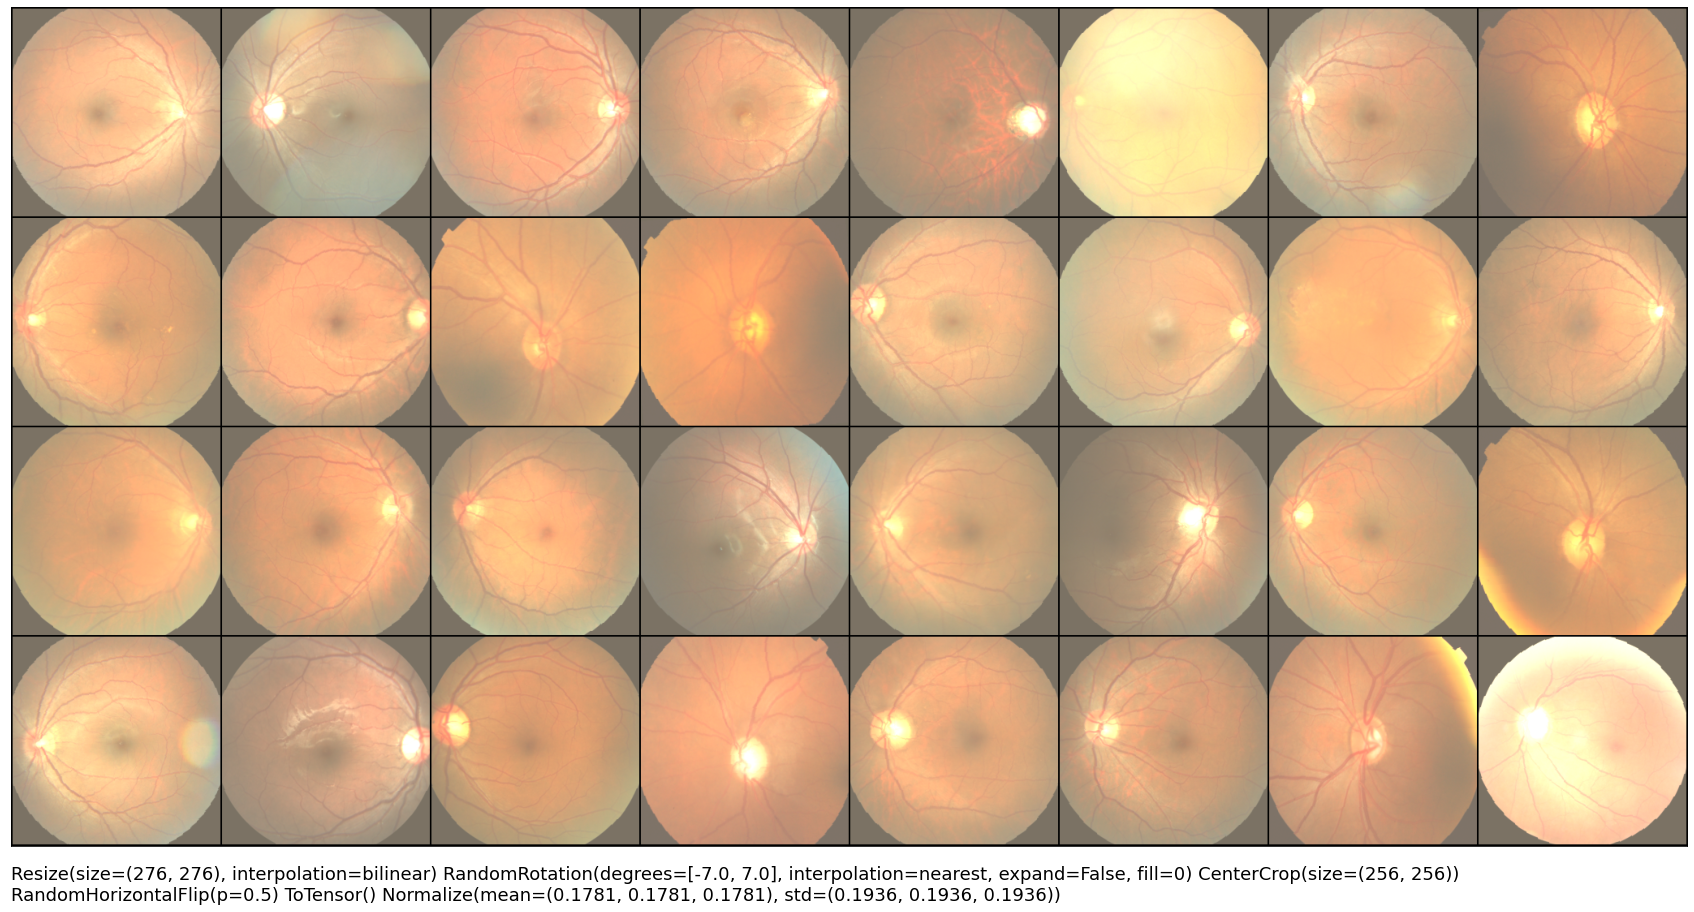

In [12]:
images, labels = next(iter(train_ldr))
fig, ax = plt.subplots(figsize=(24, 12))
ax.set_xticks([])
ax.set_yticks([])
ax.imshow(make_grid(inverse_normalize(images), nrow = 8).permute(1, 2, 0))
plt.tight_layout()

plt.annotate('\n'.join(wrap(img_transforms,160)), (0,0), (0, -20), xycoords='axes fraction', textcoords='offset points', va='top', fontsize=18)

# record images to run history
preprocessed_samples = plt.gcf()
try:
    mlflow.log_figure(preprocessed_samples, 'sample-images.png')
except Exception as e: print(e)

plt.show()

## Using Pretrained ResNet50 model

In [13]:
def get_resnet50():
    model = models.resnet50(pretrained=True)
    # Adjust last layer to 2 target classes
    num_ftrs = model.fc.in_features
    model.fc = torch.nn.Linear(num_ftrs, len(train_ds.classes))
    return model

model = get_resnet50().to(device)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /home/azureuser/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [14]:
model_summary = summary(model, input_size=(1,channels, img_height, img_width))
print(str(model_summary))

try: mlflow.log_text(str(model_summary), 'model-summary.txt')
except Exception as e: print(e)

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [1, 2]                    --
├─Conv2d: 1-1                            [1, 64, 128, 128]         9,408
├─BatchNorm2d: 1-2                       [1, 64, 128, 128]         128
├─ReLU: 1-3                              [1, 64, 128, 128]         --
├─MaxPool2d: 1-4                         [1, 64, 64, 64]           --
├─Sequential: 1-5                        [1, 256, 64, 64]          --
│    └─Bottleneck: 2-1                   [1, 256, 64, 64]          --
│    │    └─Conv2d: 3-1                  [1, 64, 64, 64]           4,096
│    │    └─BatchNorm2d: 3-2             [1, 64, 64, 64]           128
│    │    └─ReLU: 3-3                    [1, 64, 64, 64]           --
│    │    └─Conv2d: 3-4                  [1, 64, 64, 64]           36,864
│    │    └─BatchNorm2d: 3-5             [1, 64, 64, 64]           128
│    │    └─ReLU: 3-6                    [1, 64, 64, 64]           --
│ 

In [15]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

mlflow.log_params({'Architecture' : 'ResNet50',
                   'Transfer Learning' : 'Yes',
                   'Epochs' : epochs,
                   'Optim' : str(optimizer).split()[0],
                   'LR' : learning_rate,
                   'Batch size' : train_ldr.batch_size,
                   'Train size' : len(train_ds),
                   'Preprocess' : img_transforms[:255]})

In [16]:
torch.manual_seed(random_seed)
total_time_sec, time_per_epoch_sec, best_model, history = train(model = model,
                             device=device,
                             optimizer = optimizer,
                             loss_fn = torch.nn.CrossEntropyLoss(),
                             train_dl = train_ldr,
                             val_dl = val_ldr,
                             epochs = epochs)

record('Training finished after {:.1f} min ({:.1f} sec per epoch) with best validation accuracy of {:.4f}'
.format(total_time_sec/60, time_per_epoch_sec, max(history['val_acc'])))

train() called: model=ResNet, opt=Adam(lr=0.000050), epochs=15, device=cuda

Epoch   1/ 15, train loss:  0.46, train acc:  0.81, val loss:  0.33, val acc:  0.86 <- best epoch so far
Epoch   2/ 15, train loss:  0.18, train acc:  0.94, val loss:  0.09, val acc:  0.95 <- best epoch so far
Epoch   3/ 15, train loss:  0.08, train acc:  0.98, val loss:  0.09, val acc:  0.96 <- best epoch so far
Epoch   4/ 15, train loss:  0.05, train acc:  0.98, val loss:  0.02, val acc:  1.00 <- best epoch so far
Epoch   5/ 15, train loss:  0.02, train acc:  1.00, val loss:  0.02, val acc:  1.00 
Epoch   6/ 15, train loss:  0.02, train acc:  1.00, val loss:  0.02, val acc:  1.00 
Epoch   7/ 15, train loss:  0.03, train acc:  0.99, val loss:  0.06, val acc:  1.00 
Epoch   8/ 15, train loss:  0.04, train acc:  0.99, val loss:  0.04, val acc:  0.98 
Epoch   9/ 15, train loss:  0.02, train acc:  1.00, val loss:  0.01, val acc:  1.00 
Epoch  10/ 15, train loss:  0.01, train acc:  1.00, val loss:  0.01, val acc: 

## Review the training history

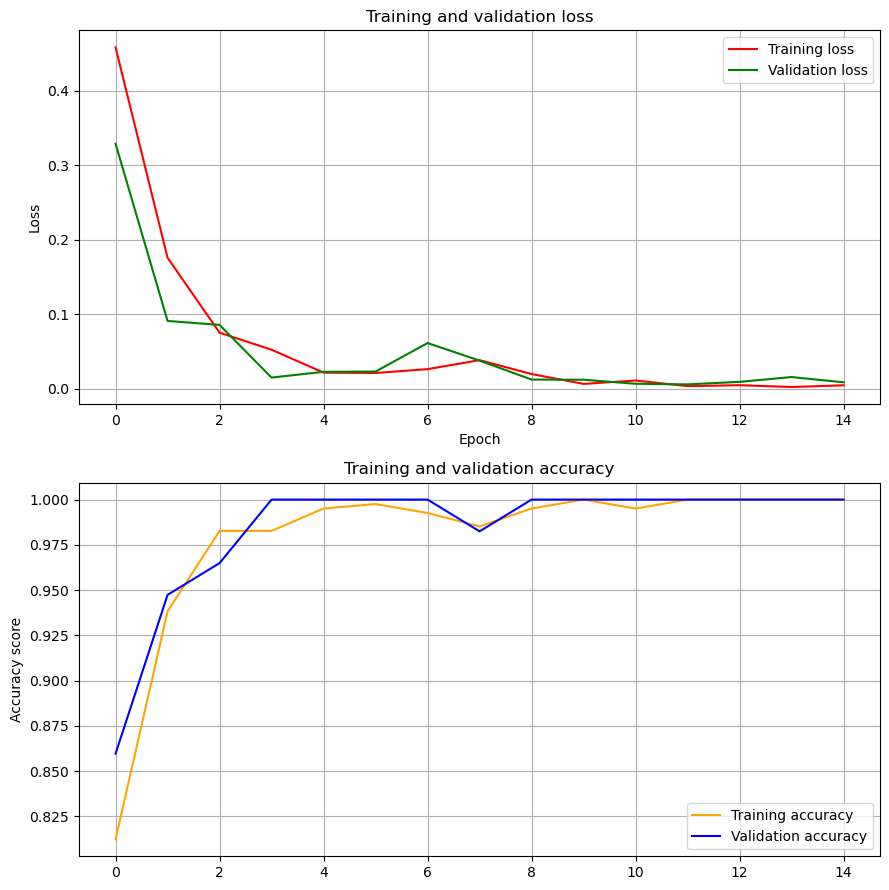

In [17]:
fig = plot_learning_curve(history)
try:
    mlflow.log_figure(fig, 'learning-curves.png')
except Exception as e: print(e)
plt.show()

## Classification report

In [18]:
y_true, y_pred, y_probs = predict_loader(model, test_ldr, device)

y_true = y_true.cpu()
y_pred = y_pred.cpu()
y_probs = y_probs.cpu()

y_true_oh = to_categorical(y_true, num_classes = len(train_ds.classes))
y_pred_oh = to_categorical(y_pred, num_classes = len(train_ds.classes))

accuracy_sc = accuracy_score(y_true, y_pred)
roc_auc_sc = roc_auc_score(y_true_oh, y_probs)

print(classification_report(y_true, y_pred, target_names = train_ds.classes))
try:
    mlflow.log_metrics({'Test Accuracy' : accuracy_sc, 'Test AUC' : roc_auc_sc})
except Exception as e: print(e)
record(f'Model evaluated on test set with accuracy of {accuracy_sc:.4f} and AUC score of {roc_auc_sc:.4f}')

              precision    recall  f1-score   support

    Glaucoma       1.00      1.00      1.00        24
Non-Glaucoma       1.00      1.00      1.00        36

    accuracy                           1.00        60
   macro avg       1.00      1.00      1.00        60
weighted avg       1.00      1.00      1.00        60

06/06/2022 18:00 : Model evaluated on test set with accuracy of 1.0000 and AUC score of 1.0000


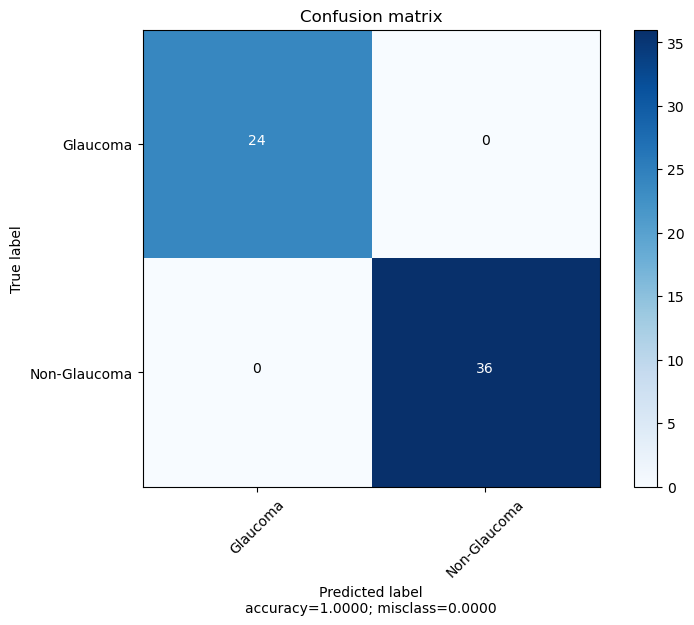

In [19]:
conf = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(conf, train_ds.classes, normalize=False)

# Define confusion matrix metadata as dict
cm_info = {"schema_type" : "confusion_matrix",
           "schema_version" : "1.0.0",
           "data" : {}}

# Add confusion_matrix from scikit-learn to dict
cm_info['data']['class_labels'] = test_ds.classes
cm_info['data']['matrix'] = conf.tolist()
json_cm_info = json.dumps(cm_info)

# log to current run in AML
try:
    amlrun.log_confusion_matrix('Test set confusion matrix', cm_info)
except Exception as e: print(e)

## Save model from the best epoch

In [20]:
torch.save(best_model.state_dict(), model_path)

## Explaining the predictions with class activation mapping

__Gradient-weighted Class Activation Mapping__ (Grad-CAM), uses the gradients of any target concept, flowing into the final convolutional layer to produce a coarse localization map highlighting important regions in the image for predicting the output. Grad-CAM is applicable to a wide variety of CNN model-families: (1) CNNs with fully-connected layers, (2) CNNs used for structured outputs, (3) CNNs used in tasks with multimodal inputs or reinforcement learning, without any architectural changes or re-training.

In [21]:
# retrieve saved model that we want to explain
model = get_resnet50()
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

## Preprocess the input images 

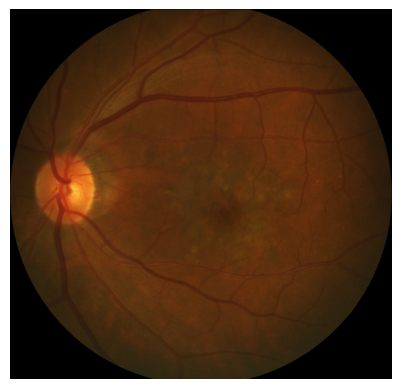

Predicted: Non-Glaucoma (0.9895)


In [22]:
model = model.to('cpu')
model.eval()
idx_to_labels = {idx : name for idx, name in enumerate(train_ds.classes)}

# Get test image for explanations
test_img = Image.open('./explain-samples/n0001.jpg')
test_img_data = np.asarray(test_img)
plt.imshow(test_img_data)
plt.axis('off')
plt.show()

# Preprocess for inference and explanations
transform = T.Compose([T.Resize((img_height, img_width)), T.ToTensor()])
transform_normalize = T.Normalize(rgb_means, rgb_stds)

transformed_img = transform(test_img)
input_img = transform_normalize(transformed_img)
input_img = input_img.unsqueeze(0) 

def predict(input_img):
    output = model(input_img)
    output = F.softmax(output, dim=1)
    prediction_score, pred_label_idx = torch.topk(output, 1)
    pred_label_idx.squeeze_()
    predicted_label = idx_to_labels[pred_label_idx.item()]
    print('Predicted: {} ({:.4f})'.format(predicted_label, prediction_score.squeeze().item()))
    return pred_label_idx, predicted_label

pred_label_idx, predicted_label = predict(input_img)

## Get Explanation for the Image

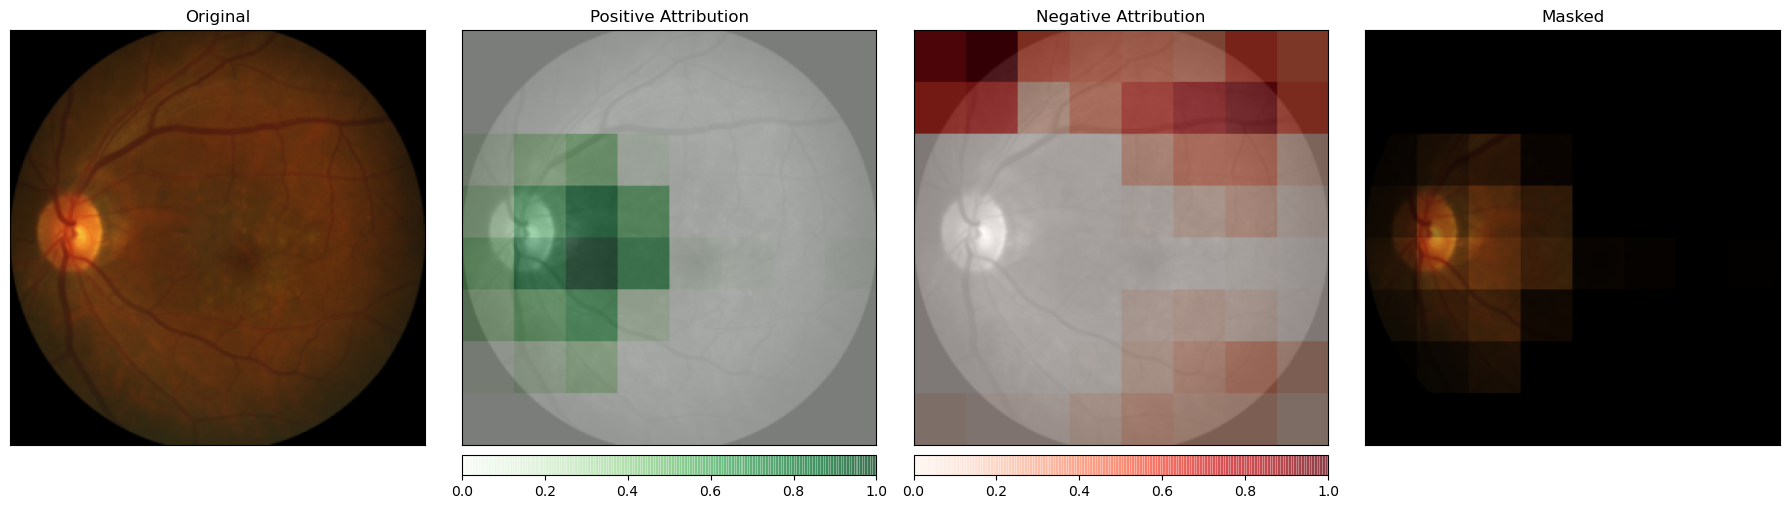

In [23]:
layer_gradcam = LayerGradCam(model, model.layer4[2].conv2)
attributions_lgc = layer_gradcam.attribute(input_img, target=pred_label_idx)
upsamp_attr_lgc = LayerAttribution.interpolate(attributions_lgc, input_img.shape[2:])

fig = viz.visualize_image_attr_multiple(upsamp_attr_lgc[0].cpu().permute(1,2,0).detach().numpy(),
                                      transformed_img.permute(1,2,0).numpy(),
                                      ["original_image", "blended_heat_map", "blended_heat_map", "masked_image"],
                                      ["all","positive","negative", "positive"],
                                      show_colorbar=True,
                                      titles=["Original", "Positive Attribution", "Negative Attribution", "Masked"],
                                      fig_size=(18, 6))

try:
    mlflow.log_figure(fig[0], 'GradCAM-explanations.png')
except Exception as e: print(e)

## Get explanation for samples of the two classes

Predicted: Glaucoma (0.9975)


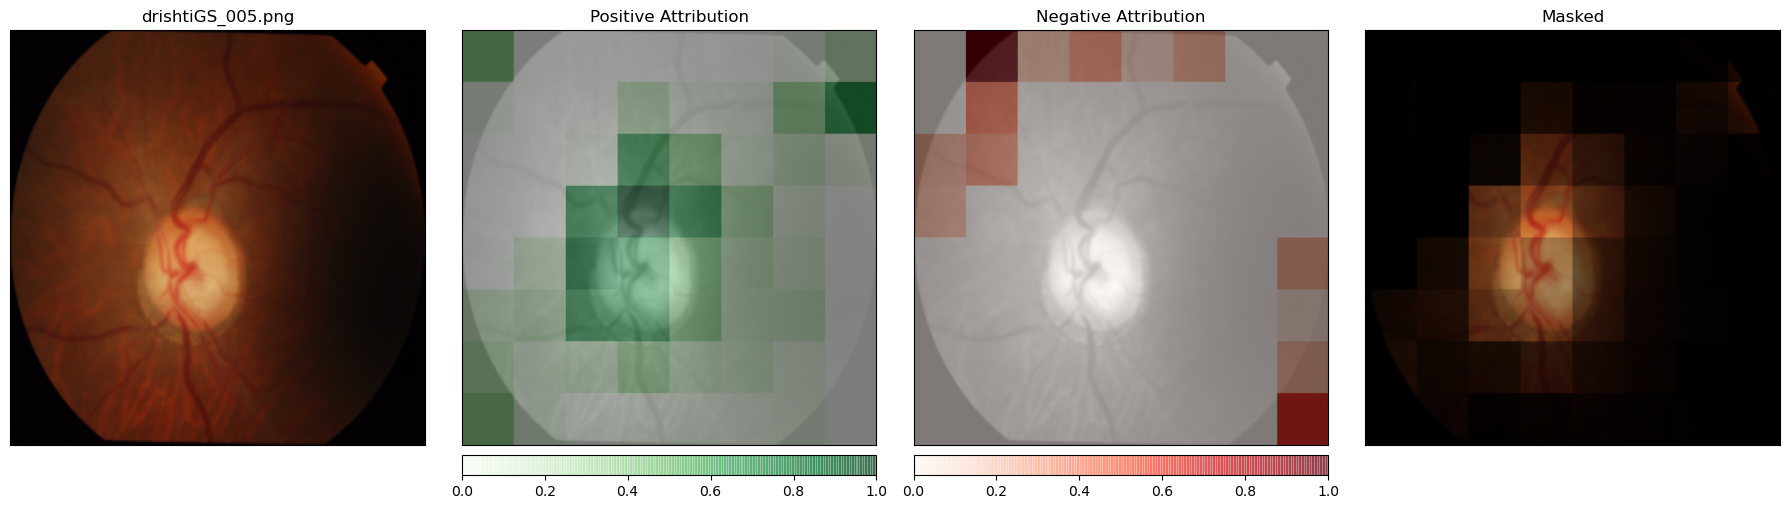

Predicted: Glaucoma (0.9507)


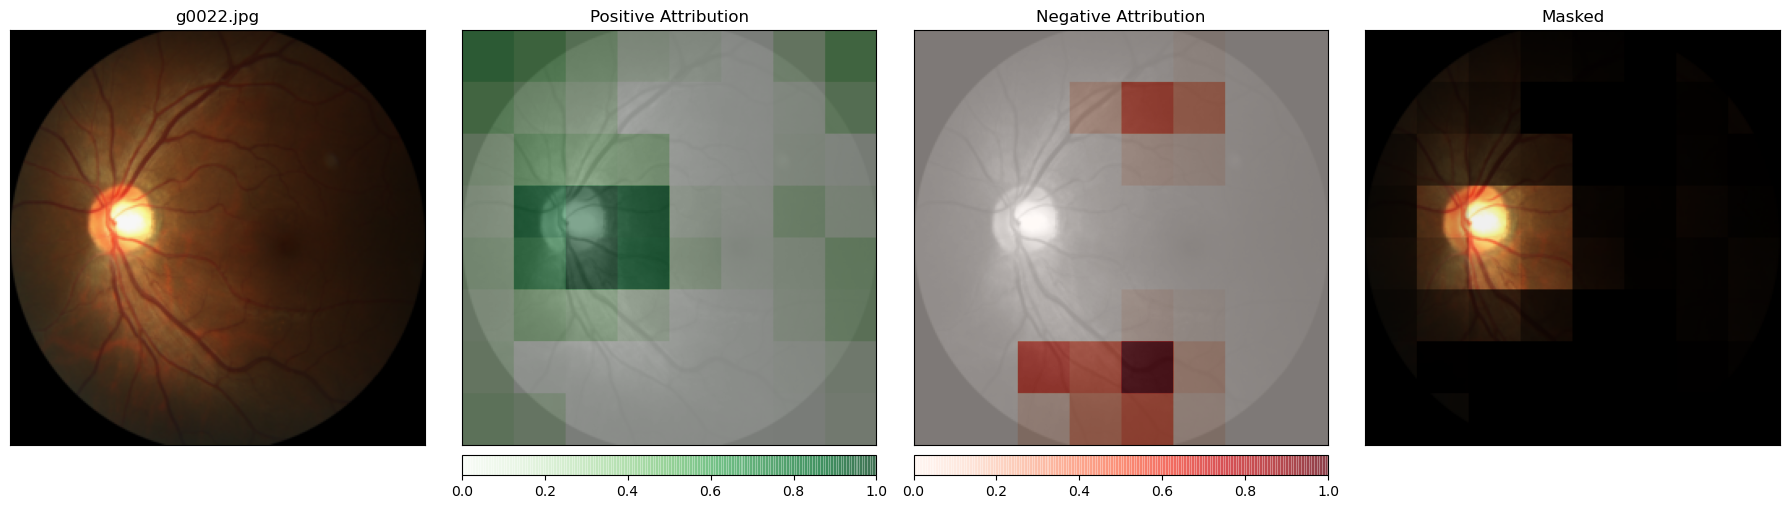

Predicted: Non-Glaucoma (0.9895)


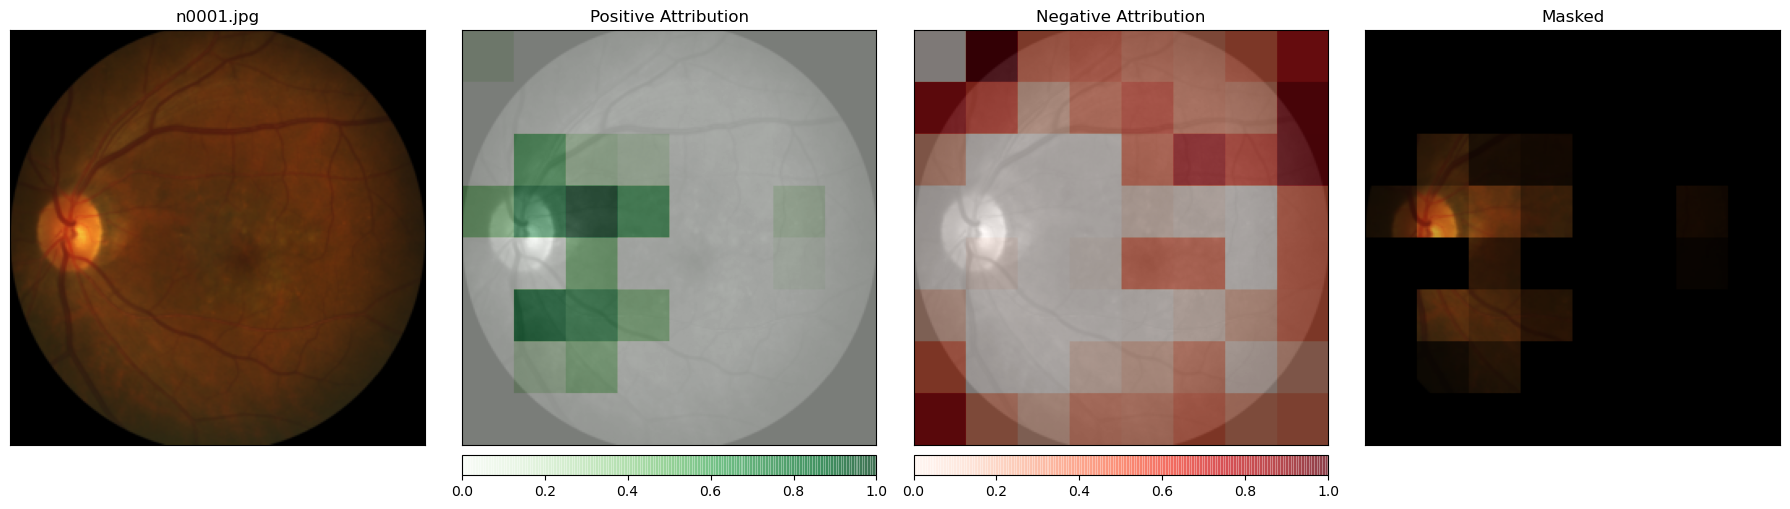

Predicted: Non-Glaucoma (0.9919)


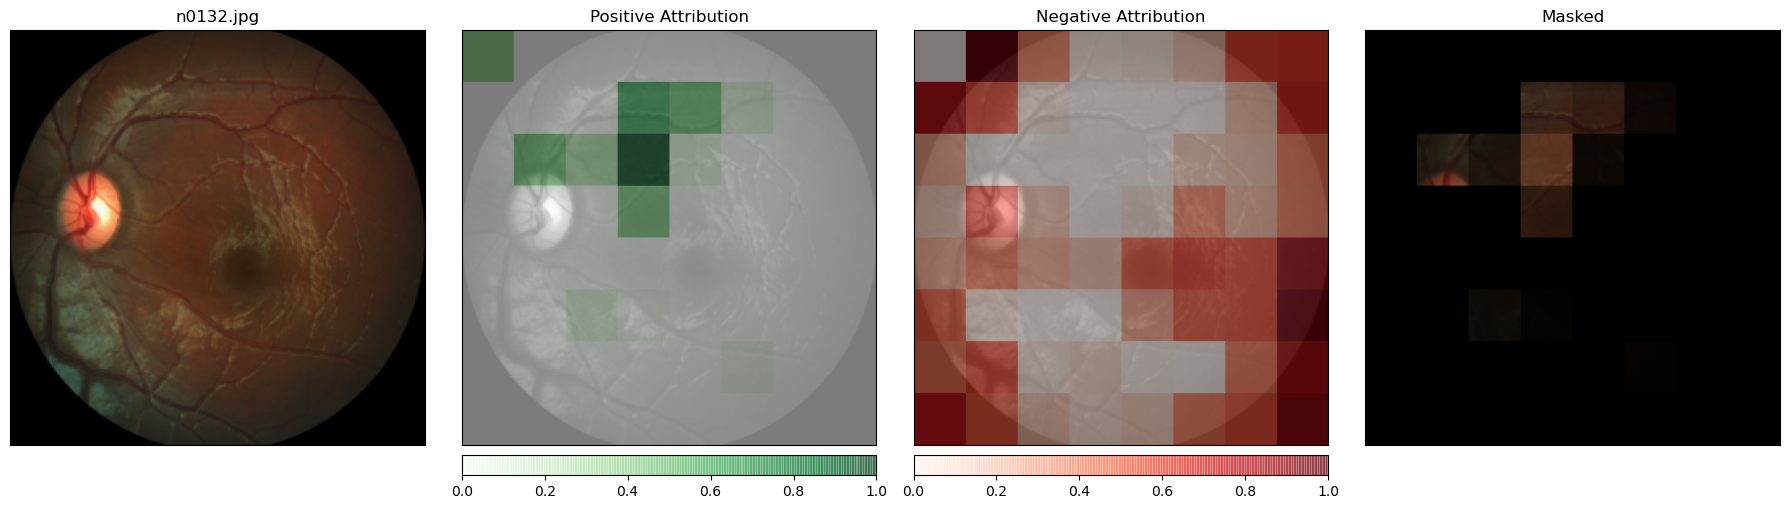

In [24]:
explain_folder = './explain-samples'

layer_gradcam = LayerGradCam(model, model.layer4[2].conv1)

img_ext =  ('png', 'jpg',  'tiff', 'bmp', 'gif')
images = [file for file in os.listdir(explain_folder) if file.lower().endswith(img_ext)]

for image_file in images:
    # preprocessing
    test_img = Image.open(os.path.join(explain_folder, image_file))
    transformed_img = transform(test_img)
    input_img = transform_normalize(transformed_img)
    input_img = input_img.unsqueeze(0) # the model requires a dummy batch dimension
        
    # get prediction
    pred_label_idx, pred_label = predict(input_img)

    # get layer attribution and upsample
    attributions_lgc = layer_gradcam.attribute(input_img, target=pred_label_idx)
    upsamp_attr_lgc = LayerAttribution.interpolate(attributions_lgc, input_img.shape[2:])

    # visualize results
    _ = viz.visualize_image_attr_multiple(upsamp_attr_lgc[0].cpu().permute(1,2,0).detach().numpy(),
                                      transformed_img.permute(1,2,0).numpy(),
                                      ["original_image","blended_heat_map","blended_heat_map", "masked_image"],
                                      ["all","positive","negative", "positive"],
                                      show_colorbar=True,
                                      titles=[image_file, "Positive Attribution", "Negative Attribution", "Masked"],
                                      fig_size=(18, 6))

## Register model in repository

In [25]:
amlrun.upload_file('glaucoma-classification.pth', model_path)

amlrun.register_model(model_name='glaucoma-classification',
                   model_path='glaucoma-classification.pth',
                   datasets = [('training', aml_dataset)],
                   model_framework=Model.Framework.PYTORCH,
                   model_framework_version=torch.__version__,
                   description='2-class glaucoma classification based on ResNet50',
                   tags={'area': 'healthcare', 'type': 'classification'}
                  )

record('Model registered in Azure ML')

06/06/2022 18:01 : Model registered in Azure ML


## Ending the experiment

In [ ]:
from mlflow import log_artifact
record('End of experiment run')
logtime = datetime.now().strftime("%d-%m-%Y-%H:%M")

try:
    mlflow.log_artifact('experiment.log')
except Exception as e: print(e)

mlflow.end_run()